In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import logging
from pathlib import Path

import numpyro

from hb_mep.config import HBMepConfig
from hb_mep.data_access import DataClass
from hb_mep.models.rats.mixed_effects import MixedEffects
from hb_mep.models.rats.utils import load_data
from hb_mep.utils import plot

numpyro.set_platform("cpu")
numpyro.set_host_device_count(12)
numpyro.enable_x64()

PARENT_PATH = Path(os.getcwd()).parent.parent.absolute()
FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

#### Load config

In [3]:
config = HBMepConfig()
config.CURRENT_PATH = PARENT_PATH

#### Load data and preprocess

In [4]:
data = DataClass(config)

""" Load """
dir_name = "physio2"
dir = os.path.join(data.data_path, dir_name)

participants = range(1, 2)

df, mat, time = load_data(dir=dir, participants=participants)

""" Filter: Ground Screw """
idx = df.channel1_segment.isna()

df = df[idx].copy()
mat = mat[idx, :, :]

""" Preprocess """
df, encoder_dict = data.build(df)

mat = mat[:, :, 0]


2023-06-14 09:50:35,966 - hb_mep.utils.utils - INFO - func:load_data took: 0.17 sec
2023-06-14 09:50:35,972 - hb_mep.data_access.core - INFO - Processing data ...
2023-06-14 09:50:35,979 - hb_mep.utils.utils - INFO - func:preprocess took: 0.01 sec
2023-06-14 09:50:35,979 - hb_mep.utils.utils - INFO - func:build took: 0.01 sec


#### Plot

In [5]:
# plot(df=df, encoder_dict=encoder_dict, mat=mat, time=time);

#### Initialize model

In [6]:
import logging
from typing import Optional

import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.diagnostics import hpdi

from hb_mep.config import HBMepConfig
from hb_mep.models.baseline import Baseline
from hb_mep.models.utils import Site as site
from hb_mep.utils import timing
from hb_mep.utils.constants import (
    INTENSITY,
    RESPONSE,
    PARTICIPANT,
    FEATURES
)

class MixedEffects(Baseline):
    def __init__(self, config: HBMepConfig):
        super(MixedEffects, self).__init__(config=config)
        self.name = "Mixed_Effects"

        self.columns = [PARTICIPANT] + FEATURES
        self.x = np.linspace(0, 450, 1000)

    def _model(self, intensity, participant, feature0, response_obs=None):
        n_data = intensity.shape[0]
        n_participant = np.unique(participant).shape[0]
        n_feature0 = np.unique(feature0).shape[0]

        with numpyro.plate("n_participant", n_participant, dim=-1):
            """ Hyper-priors """
            a_mean = numpyro.sample(
                site.a_mean,
                dist.TruncatedDistribution(dist.Normal(150, 50), low=0)
            )
            a_scale = numpyro.sample(site.a_scale, dist.HalfNormal(50))

            b_scale = numpyro.sample(site.b_scale, dist.HalfNormal(0.1))

            h_scale = numpyro.sample("h_scale", dist.HalfNormal(5))
            v_scale = numpyro.sample("v_scale", dist.HalfNormal(10))

            lo_scale = numpyro.sample(site.lo_scale, dist.HalfNormal(0.05))

            with numpyro.plate("n_feature0", n_feature0, dim=-2):
                """ Priors """
                a = numpyro.sample(
                    site.a,
                    dist.TruncatedNormal(a_mean, a_scale, low=0)
                )
                b = numpyro.sample(site.b, dist.HalfNormal(b_scale))

                h = numpyro.sample("h", dist.HalfNormal(h_scale))
                v = numpyro.sample("v", dist.HalfNormal(v_scale))

                lo = numpyro.sample(site.lo, dist.HalfNormal(lo_scale))

                gamma_scale_offset = numpyro.sample("gamma_scale_offset", dist.HalfCauchy(2.5))
                gamma_scale_slope = numpyro.sample("gamma_scale_slope", dist.HalfCauchy(2.5))

        """ Model """
        mean = numpyro.deterministic(
            site.mean,
            lo[feature0, participant] + \
            jnp.maximum(
                0,
                -1 + \
                (h[feature0, participant] + 1) / \
                jnp.power(
                    1 + \
                    (jnp.power(1 + h[feature0, participant], v[feature0, participant]) - 1) * \
                    jnp.exp(-b[feature0, participant] * (intensity - a[feature0, participant])),
                    1 / v[feature0, participant]
                )
            )
        )

        scale = numpyro.deterministic(
            "scale",
            gamma_scale_offset[feature0, participant] + \
            gamma_scale_slope[feature0, participant] * (1 / mean)
        )

        # arr = np.array([feature0, participant])
        # feature0_unq, participant_unq = np.unique(ar=arr, axis=-1)

        # delta = numpyro.deterministic(
        #     "delta",
        #     a[1, feature0_unq, participant_unq] - a[0, feature0_unq, participant_unq]
        # )

        """ Observation """
        with numpyro.plate(site.data, n_data):
            return numpyro.sample(
                site.obs,
                dist.Gamma(mean * scale, scale),
                obs=response_obs
            )

    @timing
    def run_inference(self, df: pd.DataFrame) -> tuple[numpyro.infer.mcmc.MCMC, dict]:
        """
        Run MCMC inference
        """
        response = df[RESPONSE].to_numpy().reshape(-1,)
        participant = df[PARTICIPANT].to_numpy().reshape(-1,)
        feature0 = df[FEATURES[0]].to_numpy().reshape(-1,)
        intensity = df[INTENSITY].to_numpy().reshape(-1,)

        # MCMC
        nuts_kernel = NUTS(self._model)
        mcmc = MCMC(nuts_kernel, **self.config.MCMC_PARAMS)
        rng_key = jax.random.PRNGKey(self.random_state)
        # logger.info(f"Running inference with {self.name} ...")
        mcmc.run(rng_key, intensity, participant, feature0, response)
        posterior_samples = mcmc.get_samples()

        return mcmc, posterior_samples

    def _get_threshold_estimates(
        self,
        combination: tuple,
        posterior_samples: dict,
        prob: float = .95
    ):
        threshold_posterior = posterior_samples[site.a][
            :, combination[1], combination[0]
        ]
        threshold = threshold_posterior.mean()
        hpdi_interval = hpdi(threshold_posterior, prob=prob)
        return threshold, threshold_posterior, hpdi_interval

    def predict(
        self,
        intensity: np.ndarray,
        combination: tuple,
        posterior_samples: Optional[dict] = None,
        num_samples: int = 100
    ):
        predictive = Predictive(model=self._model, num_samples=num_samples)
        if posterior_samples is not None:
            predictive = Predictive(model=self._model, posterior_samples=posterior_samples)

        participant = np.repeat([combination[0]], intensity.shape[0])
        feature0 = np.repeat([combination[1]], intensity.shape[0])

        predictions = predictive(
            self.rng_key,
            intensity=intensity,
            participant=participant,
            feature0=feature0
        )
        return predictions



In [7]:
model = MixedEffects(config)

2023-06-14 09:50:36,207 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
2023-06-14 09:50:36,208 - jax._src.xla_bridge - INFO - Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-06-14 09:50:36,208 - jax._src.xla_bridge - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-06-14 09:50:36,208 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
2023-06-14 09:50:36,209 - jax._src.xla_bridge - INFO - Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


#### Run MCMC inference

In [8]:
mcmc, posterior_samples = model.run_inference(df=df)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-06-14 09:52:12,635 - hb_mep.utils.utils - INFO - func:run_inference took: 1 min and 36.32 sec


#### Diagnostics

In [9]:
mcmc.print_summary(prob=.95)


                             mean       std    median      2.5%     97.5%     n_eff     r_hat
                 a[0,0]     15.25      3.56     15.59      8.05     21.92   6912.05      1.00
                 a[1,0]     82.91      2.82     82.90     77.40     88.33  13987.81      1.00
                 a[2,0]     20.75      5.60     21.51      9.11     29.68   5276.79      1.00
                 a[3,0]     50.84      3.61     51.65     42.50     56.59   6776.28      1.00
                 a[4,0]     57.56      4.03     57.66     49.56     65.13  13715.53      1.00
                 a[5,0]     21.08      3.20     21.25     14.52     27.03  14362.66      1.00
                 a[6,0]     54.43      2.51     54.85     48.96     58.66  12257.22      1.00
                 a[7,0]     42.87      3.03     43.19     37.04     48.48  10135.92      1.00
                 a[8,0]     79.64      4.58     80.25     70.06     87.78  10681.16      1.00
              a_mean[0]     45.47     14.33     46.64     1

#### Plot fitted curves

2023-06-14 09:54:20,477 - hb_mep.utils.utils - INFO - func:plot took: 1 min and 49.26 sec


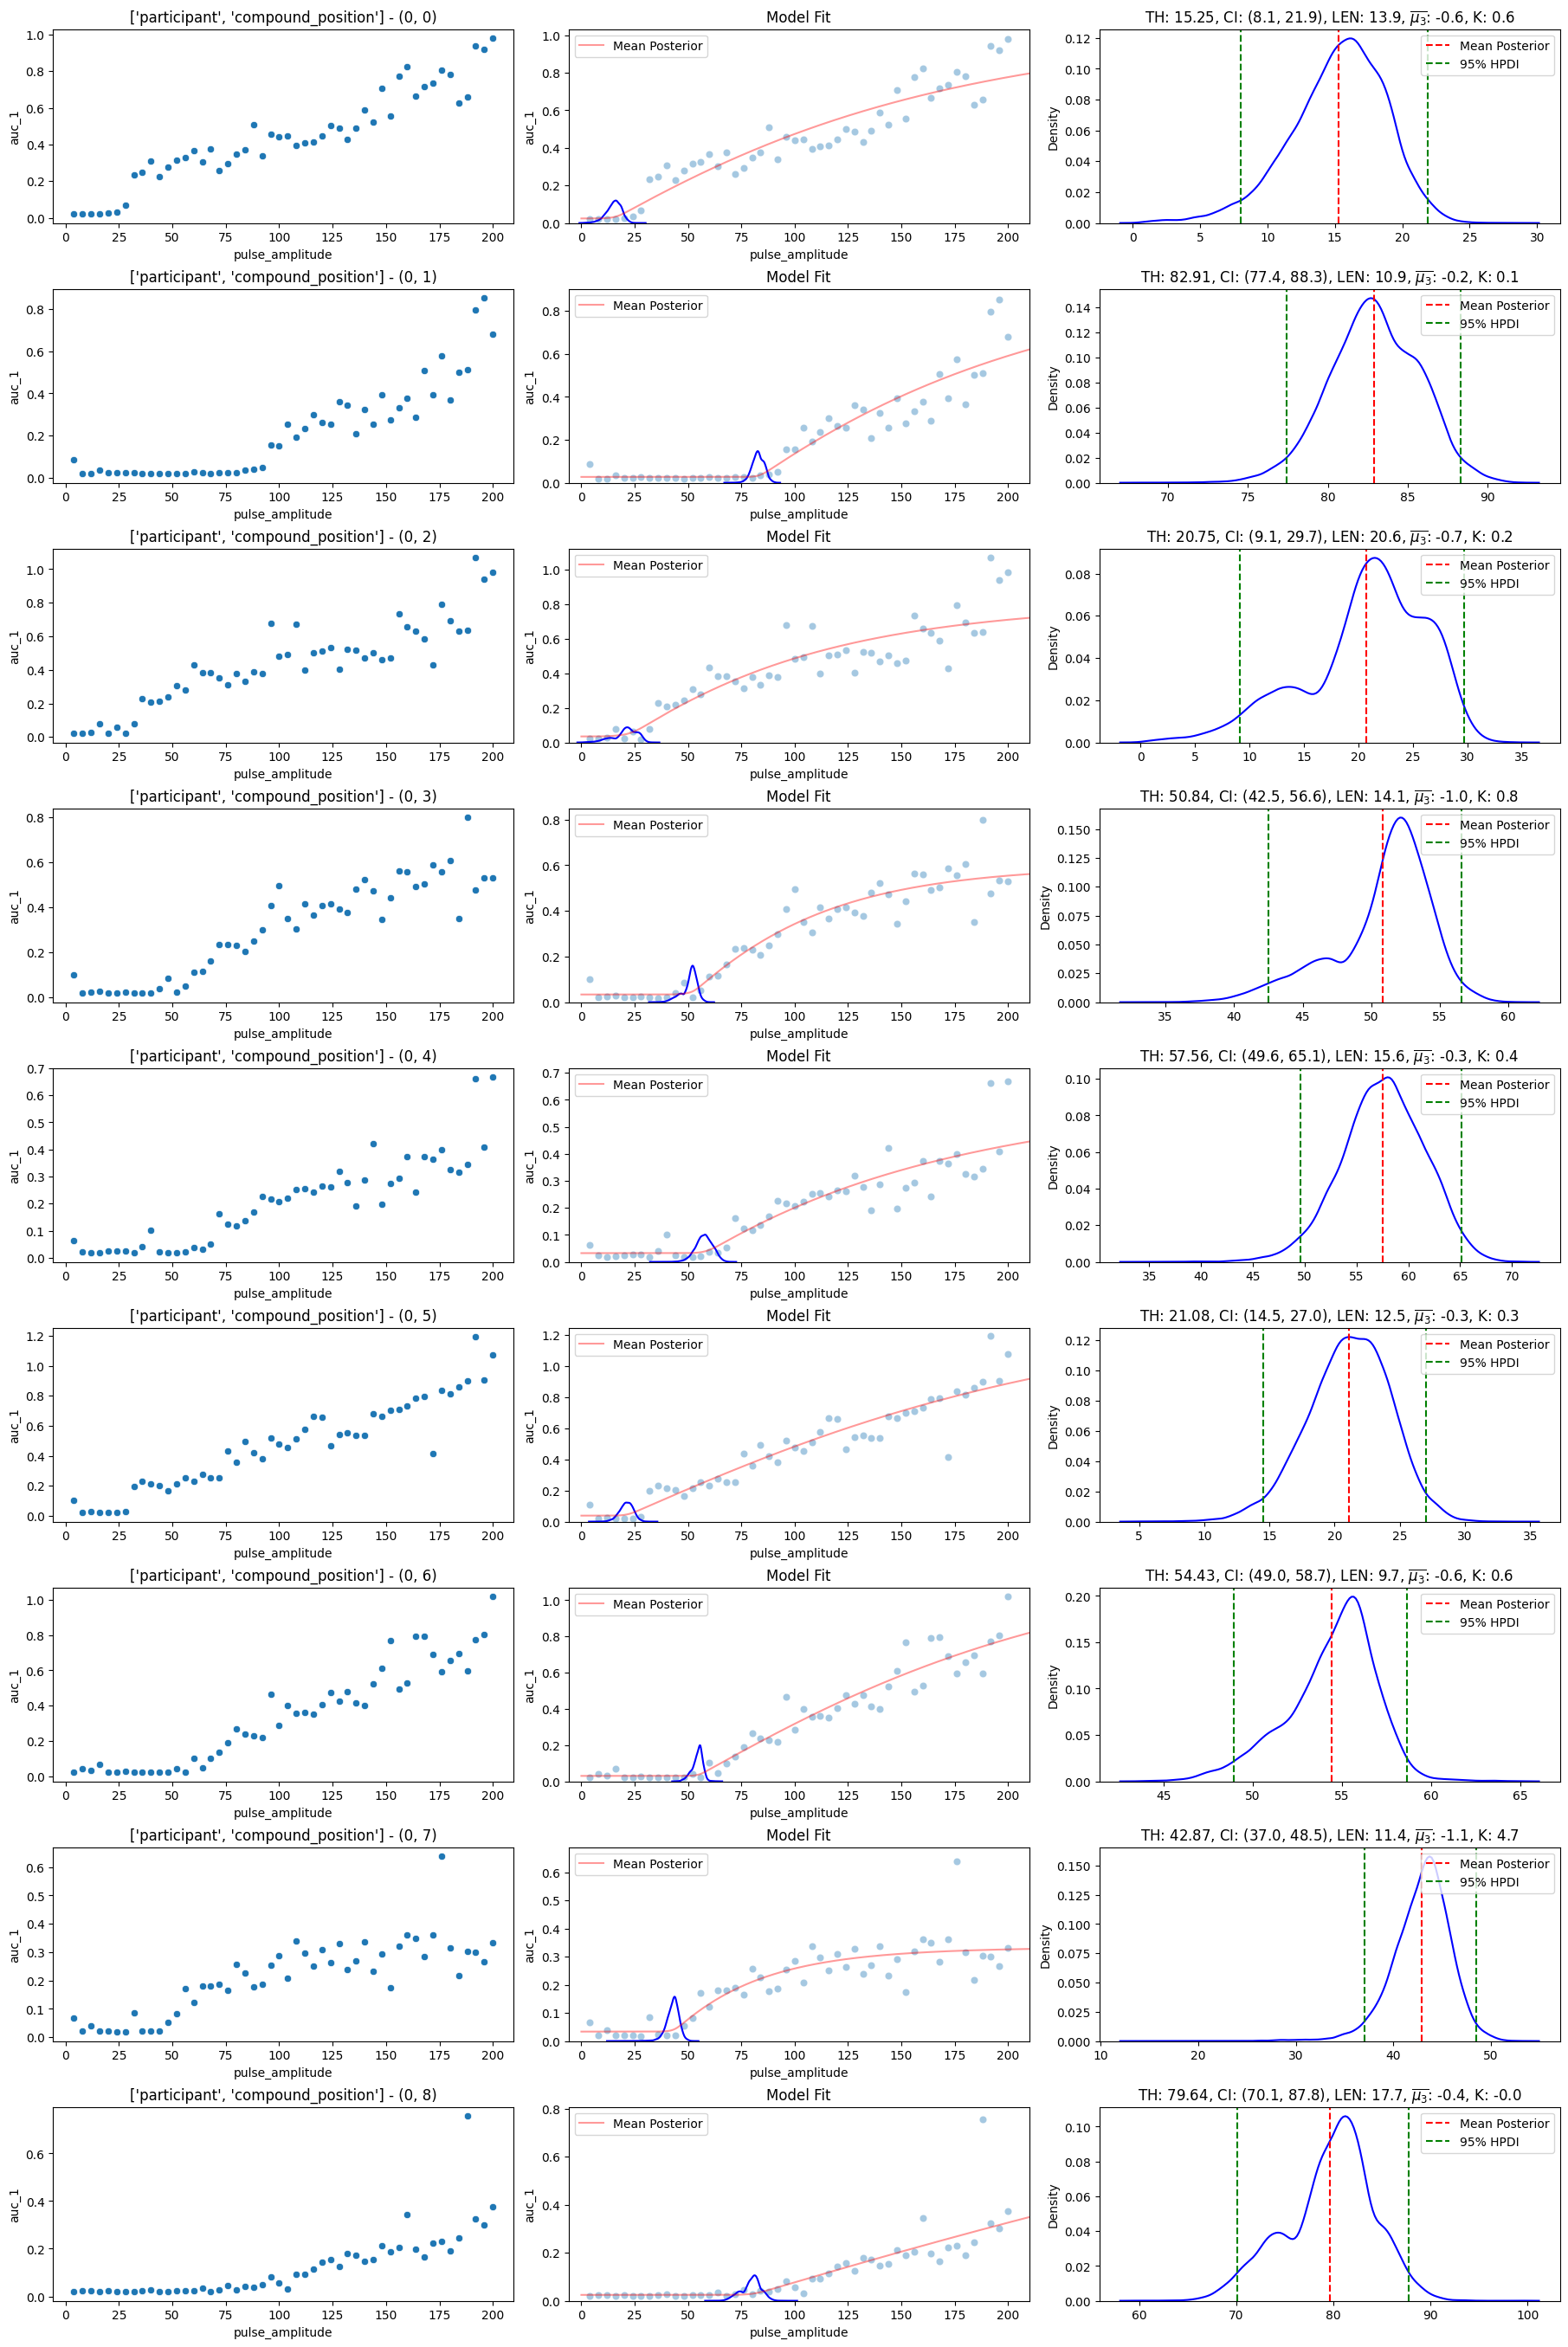

In [11]:
model.plot(df=df, posterior_samples=posterior_samples);

#### Posterior Predictive Check

2023-06-14 09:57:03,513 - hb_mep.utils.utils - INFO - func:predictive_check took: 2 min and 38.91 sec


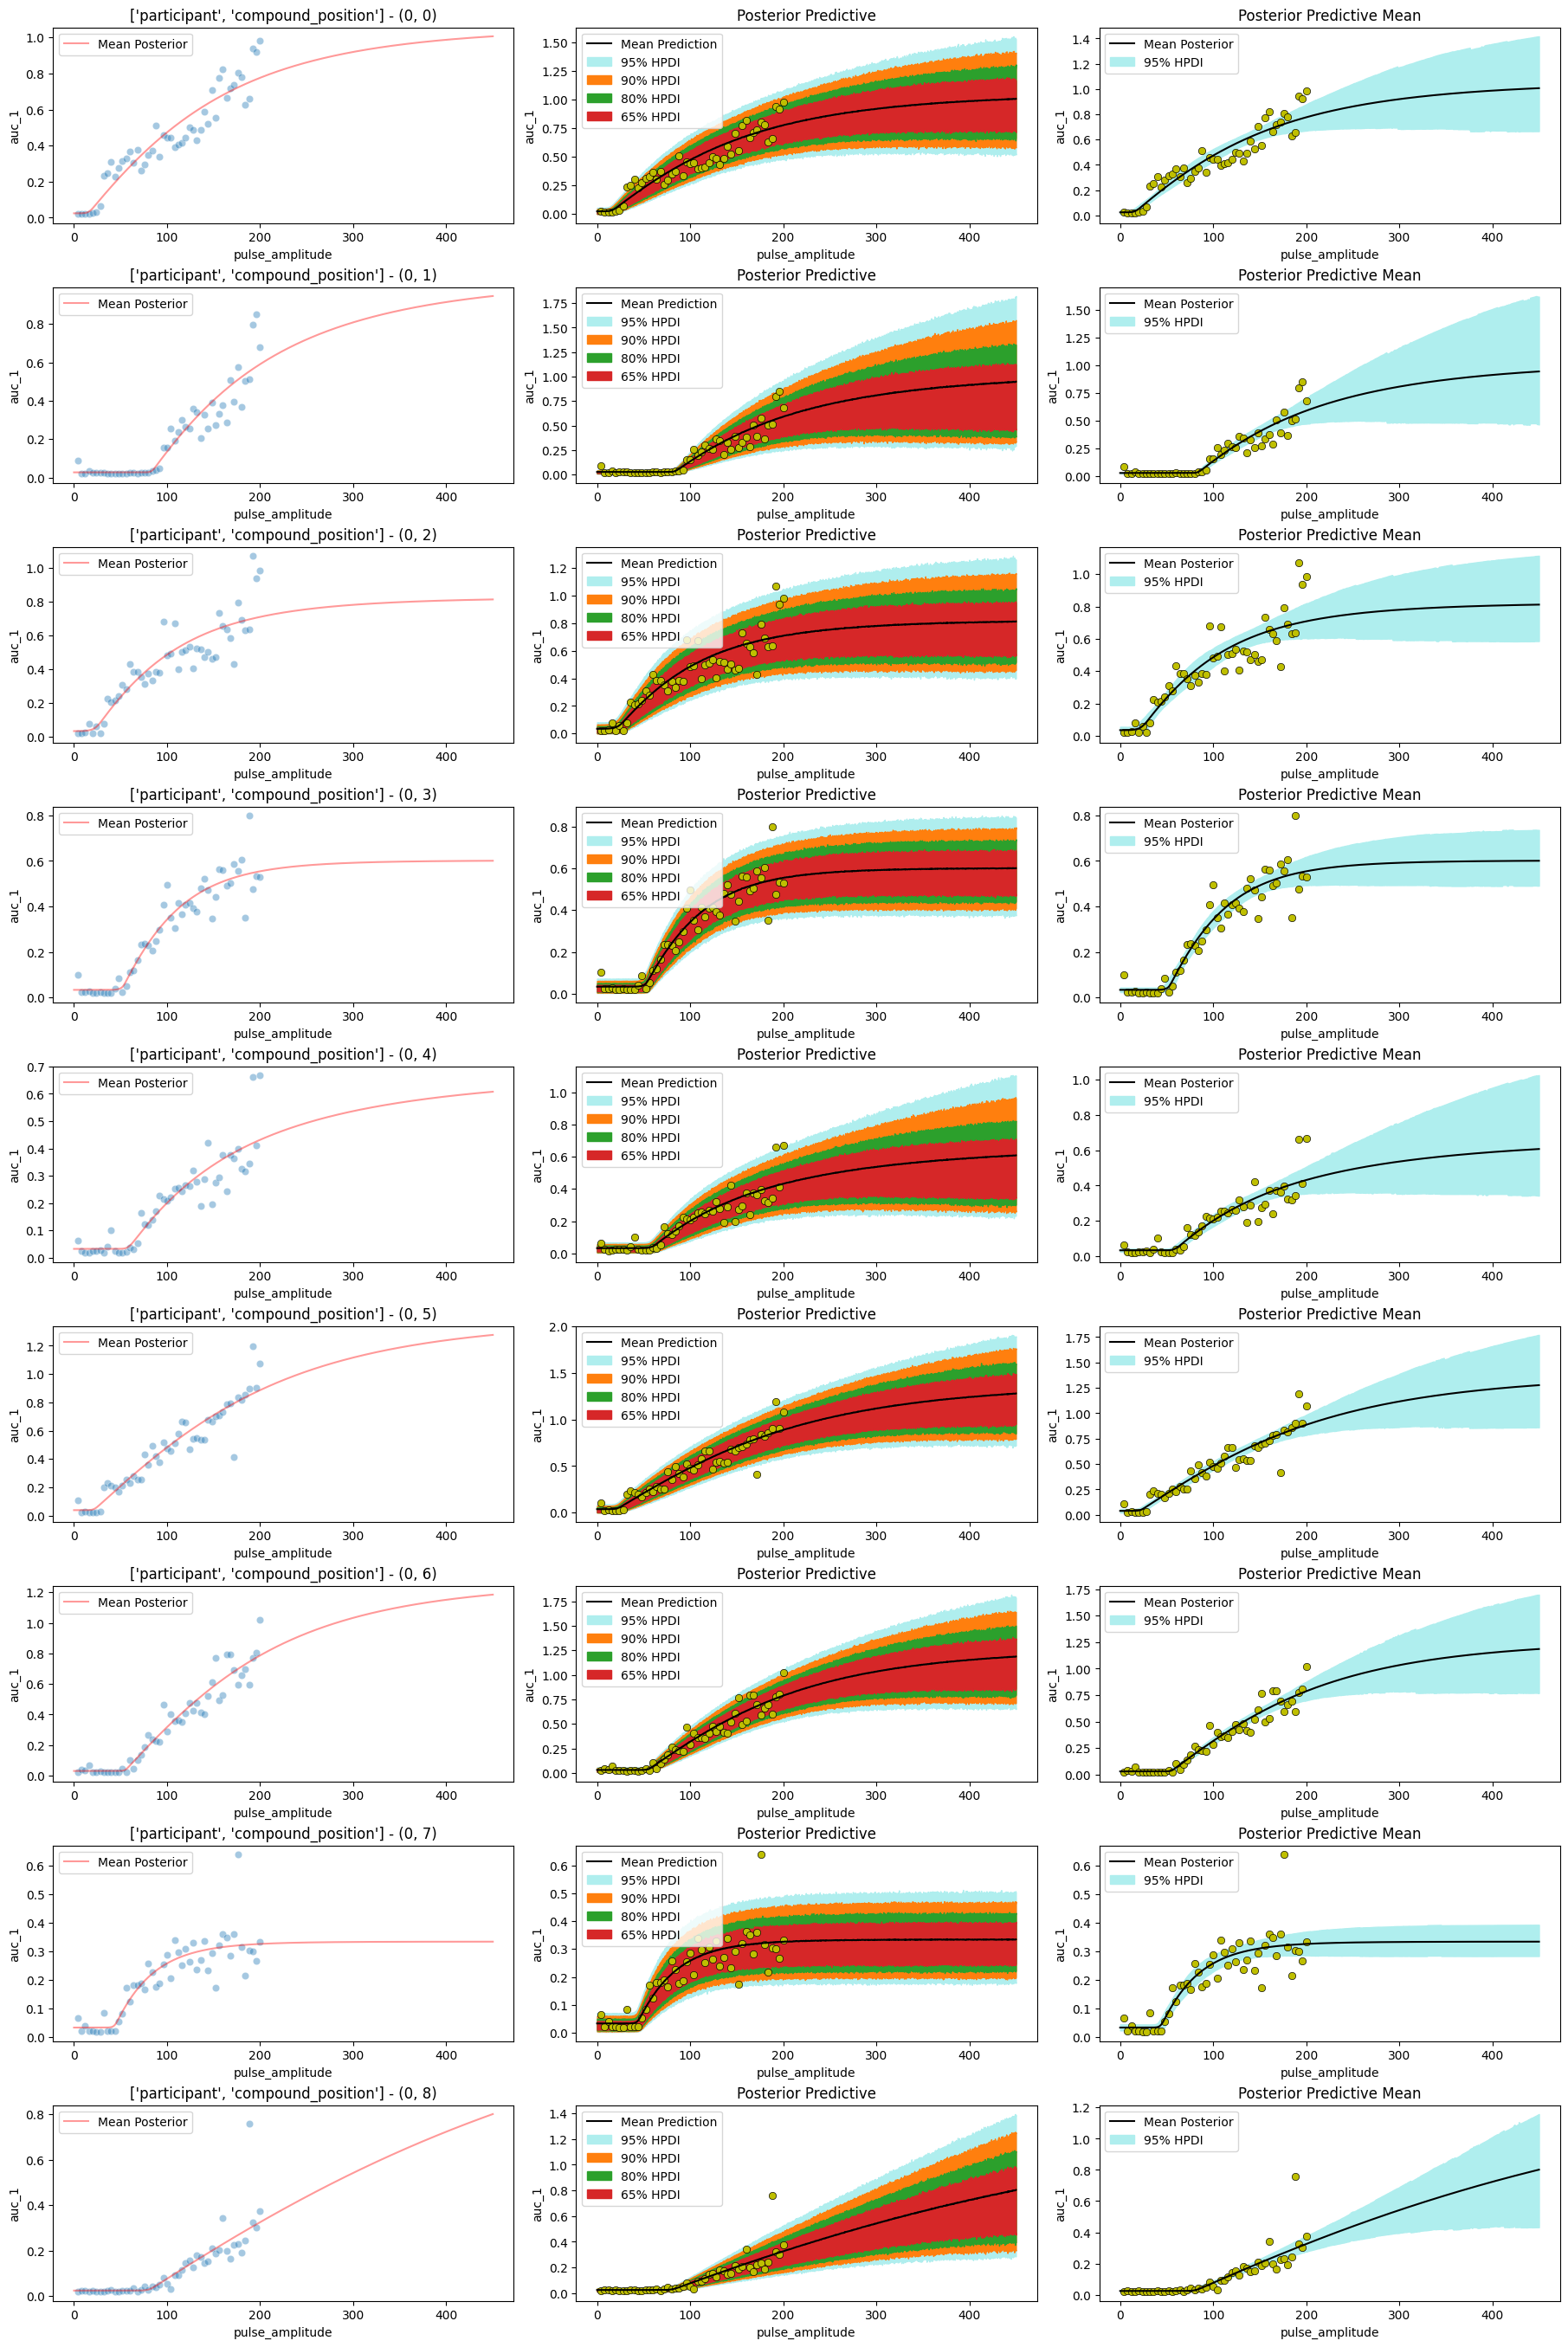

In [12]:
model.predictive_check(df=df, posterior_samples=posterior_samples);

In [13]:
a = posterior_samples["a"]

In [17]:
a.shape

(24000, 9, 1)

In [22]:
arr = np.array([df[].tolist(), df[FEATURES[0]].tolist()])

0      6
1      2
2      8
3      3
4      4
      ..
445    0
446    3
447    2
448    4
449    5
Name: compound_position, Length: 450, dtype: int64

In [19]:
df.participant

0      0
1      0
2      0
3      0
4      0
      ..
445    0
446    0
447    0
448    0
449    0
Name: participant, Length: 450, dtype: int64

In [32]:
arr = np.array([df[PARTICIPANT].tolist(), df[FEATURES[0]].tolist()])

In [53]:
map(np.unique(arr, axis=-1)

[(0, 0, 0, 0, 0, 0, 0, 0, 0), (0, 1, 2, 3, 4, 5, 6, 7, 8)]

In [27]:
df.participant

0      0
1      0
2      0
3      0
4      0
      ..
445    0
446    0
447    0
448    0
449    0
Name: participant, Length: 450, dtype: int64

<Axes: ylabel='Density'>

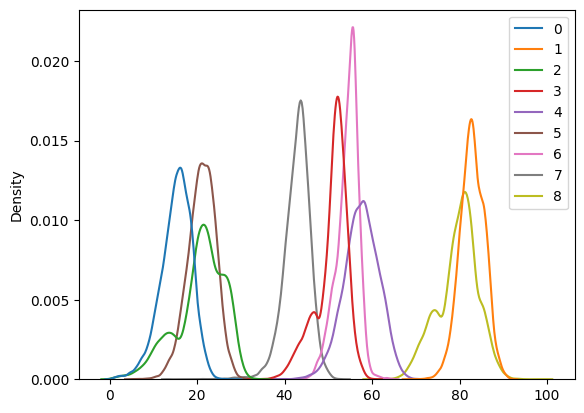

In [26]:
sns.kdeplot(a[:, :, 0])

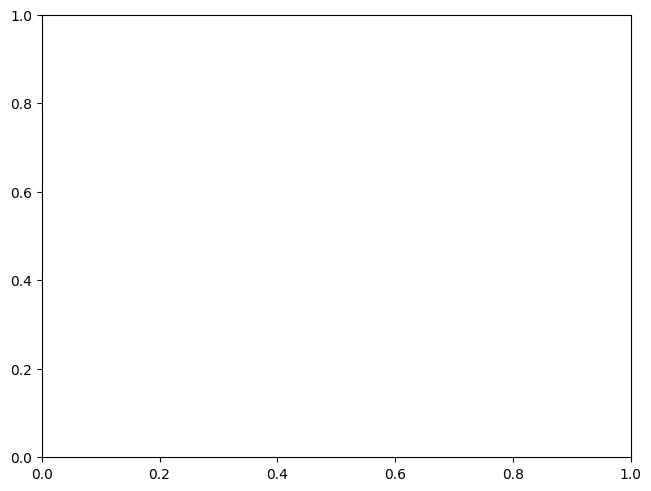

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns


n_participants = len(participants)

fig, ax = plt.subplots(nrows=n_participants, ncols=1, constrained_layout=True)

for i in range(n_participants):
    for j in range(a)
